In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("../data/train_embedded_bert.csv")
df_train["sentence_embedding"] = df_train["sentence_embedding"].apply(
    lambda x: np.array([float(value) for value in x[1:-1].split(",")]))

df_test = pd.read_csv("../data/test_embedded_bert.csv")
df_test["sentence_embedding"] = df_test["sentence_embedding"].apply(
    lambda x: np.array([float(value) for value in x[1:-1].split(",")]))

In [6]:
def label_to_one_hot(label):
    one_hot = [0, 0, 0]
    one_hot[label] = 1
    return one_hot


df_train["yhot"] = df_train["label"].apply(label_to_one_hot)

In [7]:
X_train = np.zeros(shape=(len(df_train), 768))
for i in range(len(df_train)):
    X_train[i] = df_train["sentence_embedding"].values[i]

In [8]:
y_train = np.zeros(shape=(len(df_train), 3))
for i in range(len(df_train)):
    y_train[i] = df_train["yhot"].values[i]
y_train = y_train.astype(int)

In [32]:
# define baseline model
def baseline_model(metric="accuracy"):
    # create model
    model = Sequential()

    # Rectified Linear Unit Activation Function
    model.add(Dense(128, input_dim=768, activation='relu'))
    model.add(Dense(64, activation='relu'))  # Softmax for multi-class classification
    model.add(Dense(3, activation='softmax'))  # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metric])
    return model

ACCURACY metric

In [34]:
model = baseline_model(metric="accuracy")
history = model.fit(X_train, y_train, validation_split=0.33,
epochs=200, batch_size=100, verbose=False)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


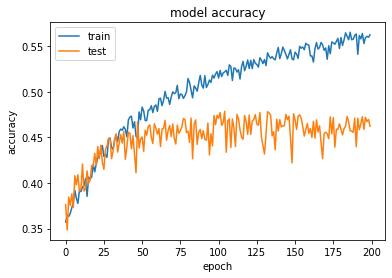

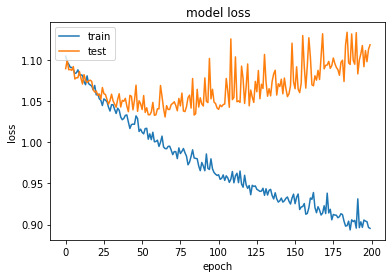

In [35]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC ROC metric

In [36]:
model = baseline_model(metric="AUC")
history = model.fit(X_train, y_train, validation_split=0.33, epochs=200, batch_size=100, verbose=False)

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


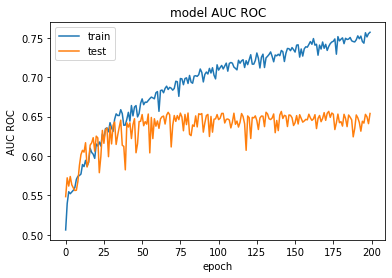

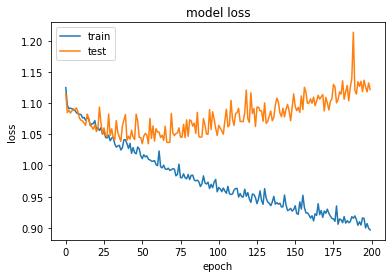

In [37]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict df_test with ANN

In [38]:
X_test = np.zeros(shape=(len(df_test), 768))
for i in range(len(df_test)):
    X_test[i] = df_test["sentence_embedding"].values[i]

In [41]:
prediction = model.predict(X_test)

In [43]:
prediction

array([[0.25977132, 0.55005646, 0.19017226],
       [0.04367387, 0.9037811 , 0.05254497],
       [0.5824158 , 0.30148196, 0.11610224],
       ...,
       [0.8026298 , 0.10946579, 0.08790436],
       [0.40710247, 0.4169509 , 0.17594656],
       [0.28129554, 0.11769836, 0.60100615]], dtype=float32)

In [47]:
df_test["prediction_hot"] = [row for row in prediction]

In [48]:
df_test["prediction"] = df_test["prediction_hot"].apply(lambda x : np.array(x).argmax())

In [50]:
submission = df_test[["id","prediction"]]

In [51]:
submission.to_csv("../data/submission_ann.csv")